## Optimised Image Stitching

Image Analysis and Manipulation Functions

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import imutils
import cv2 as cv

################################################
# Function that creates the SIFT feature detector 
################################################
def detectAndDescribe( image):
    descriptor = cv.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    return (kps, features)

################################################
# Function that matches the points from one image
# to the next
################################################
def matchKeypoints( kpsA, kpsB, featuresA, featuresB,
    ratio, reprojThresh):

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(featuresA,featuresB,k=2)
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kpsB[m.trainIdx].pt)
            pts1.append(kpsA[m.queryIdx].pt)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good)>10:
        src_pts = np.float32([ kpsA[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kpsB[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    #Pts1 is shape (N,2), where N in number of points
    # src_pts = np.float32(pts1).reshape(-1,1,2)
    # dst_pts = np.float32(pts2).reshape(-1,1,2)

    # (H, status) = cv.findHomography(np.array([pts1]), np.array([pts2]), cv.RANSAC,reprojThresh)
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,reprojThresh)
    matchesMask = mask.ravel().tolist()

    return H,good,matchesMask


def transformImWide(image,outputImageSize):
    # print(T)
    T = np.eye(3)
    warp = cv.warpPerspective(image.copy(), T, (outputImageSize[1], outputImageSize[0]))
    return warp


###############################################
# After the Homography is applied to the image the 4 corners are no longer 
# the 4 corners of the image matrix. Instead they are shifted. The code
# Below find these corners.
################################################    
def CalcCorners(H,src):

    cornersX = np.zeros((2,2))
    cornersY = np.zeros((2,2))

    #Top Left
    V2 = np.array(([0],[0],[1]))
    V1 = H@V2

    cornersX[0,0] = V1[0] / V1[2]
    cornersY[0,0] = V1[1] / V1[2]

    #Bottom Left
    V2 = np.array(([0],[src.shape[0]],[1]))

    V1 = H@V2
    cornersX[1,0] = V1[0] / V1[2]
    cornersY[1,0] = V1[1] / V1[2]

    #Top Right
    V2 = np.array(([src.shape[1]],[0],[1]))

    V1 = H@V2
    cornersX[0,1] = V1[0] / V1[2]
    cornersY[0,1] = V1[1] / V1[2]

    #Bottom Right
    V2 = np.array(([src.shape[1]],[src.shape[0]],[1]))

    V1 = H@V2
    cornersX[1,1] = V1[0] / V1[2]
    cornersY[1,1] = V1[1] / V1[2]

    if cornersY[1,1] > src.shape[0]:
        grad = (cornersY[1,1]-cornersY[0,1])/(cornersX[1,1]-cornersX[0,1])
        b = cornersY[0,1] - grad*cornersX[0,1]

        cornersX[1,1] = (src.shape[0] -b)/grad
        cornersY[1,1] = src.shape[0]

        if cornersY[0,1] < 0:
            cornersX[0,1] = (-b)/grad
            cornersY[0,1] = 0

    return cornersX,cornersY

################################################
# Function that optimises the seam that gets 
# created when overlaying two images

# This function makes use of weighted fusion, 
# slowly transitioning from the previous image 
# to the second image in the overlapping part, 
# that is, adding the pixel value of the overlapping 
# area of the image to a certain weight to form a new image.
################################################   
def optimizeSeam(img1, transImage,dst,cornersX,cornersY):
    # from time import time

    # t1 = time()

    start = int(np.minimum(cornersX[0,0], cornersX[1,0]))

    processWidth = img1.shape[1] - start
    rows = dst.shape[0]
    cols = img1.shape[1]

    temp = np.zeros_like(dst)
    temp[0:img1.shape[0], 0:img1.shape[1]] = img1

    a = np.arange(transImage.shape[1])[None]
    a = np.repeat(a,transImage.shape[0],0)
    z = ((transImage[:,:,:]==0).sum(axis=2)==3).astype(float)

    z[np.where((z==0) & (a>=start) & (a<cols))] = (processWidth+start)/processWidth
    a[np.where((a<start))] = 0
    a[np.where((a>=cols))] = 0
    a[np.where(z==1)] = 0
    a = a/processWidth
    x = z-a
    x = np.repeat(x[...,None],3,2)

    myk = np.multiply(transImage,1-x).astype(np.uint8)

    myl = np.multiply(temp,x).astype(np.uint8)

    res = myk + myl
    # t2 = time()
    # print("New Method in " + str(t2-t1)+" seconds")


    # for i in range(rows):

    #     for j in range(start,cols):
       
    #         # if(transImage[i,j,0]==0 & transImage[i,j,1]==0 & transImage[i,j,2] == 0):
    #         if ((transImage[i,j,:]==0).all()):
    #             #If the blending area is black then no need to blend
    #             alpha=1
    #         else:
    #             alpha = (processWidth - (j - start)) / processWidth
    #             # ((processWidth + start)/ processWidth)  - (j/processWidth)
 
    #         dst[i,j,:] = img1[i,j,:]* alpha + transImage[i,j,:] * (1 - alpha)
    
    # t3 = time()
    # print("old Method in " + str(t3-t2)+" seconds")

    # return dst
    return res

    
################################################
# Function to ease the displaying of 
# Matplots in the notebook
################################################
def show_cv_image(img):
    plt.figure()
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # remove unnecessary ticks
    plt.axis("off")
    plt.imshow(rgb_img)

Reading the Images; Finding and matching features

In [13]:
imageL = cv.imread("Images/to_stitch/labLeft.png",1) 
imageR = cv.imread("Images/to_stitch/labRight.png",1)

############################################
# Detecting Features
############################################
(kpsA, featuresA) = detectAndDescribe(cv.cvtColor(imageR, cv.COLOR_BGR2GRAY))
(kpsB, featuresB) = detectAndDescribe(cv.cvtColor(imageL, cv.COLOR_BGR2GRAY))

############################################
# Match features between the 2 images
############################################
H,good,matchesMask = matchKeypoints(kpsA, kpsB,featuresA, featuresB, 0.75, 4.0)

############################################
# Find Corners of warped Image
############################################
print(H)
cornersX,cornersY =  CalcCorners(H,imageR)


[[ 7.15940373e-01 -3.69898472e-02  1.17905431e+03]
 [-1.54421893e-01  9.10201815e-01  1.39194066e+02]
 [-9.78361873e-05  9.22074420e-07  1.00000000e+00]]


Applying the homography

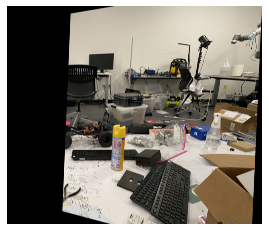

In [14]:

############################################
# Warping the Right Image
############################################
result = cv.warpPerspective(imageR, H,(int(cornersX.max(axis=0)[1]), imageR.shape[0]))
imWarped = result.copy()
show_cv_image(imWarped)


Adding the warped image to the normal image

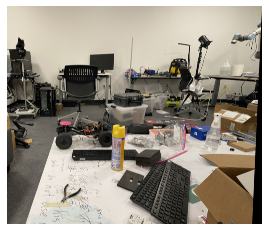

In [15]:
###########################################
# Adding the two images together
############################################
# imB = transformImWide(imageL,result.shape)
# result = alphaBlend(result,imB)
result[0:imageR.shape[0], 0:imageR.shape[1]] = imageL

show_cv_image(result)

Applying the Image Blending to fix the seam

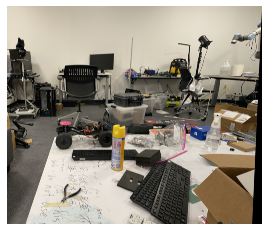

In [16]:
############################################
# Fixing the image seam
############################################
optim = optimizeSeam(imageL,imWarped,result,cornersX,cornersY)
show_cv_image(optim)

Fixing the Borders

True

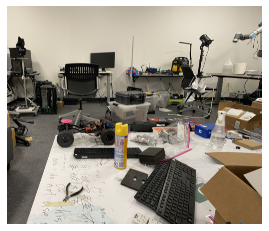

In [17]:
############################################
# Fixing the black border areas
############################################
sourcePts = np.float32([[0,0],[0,optim.shape[0]],[cornersX[0,1],cornersY[0,1]],[cornersX[1,1],cornersY[1,1]]])
destPts = np.float32([[0,0],[0,optim.shape[0]],[optim.shape[1],0],[optim.shape[1],optim.shape[0]]])
T = cv.getPerspectiveTransform(sourcePts, destPts)
final = cv.warpPerspective(optim.copy(), T, (optim.shape[1], optim.shape[0]))   
show_cv_image(final)
cv.imwrite('Images/stitched/stiched.png',final)

In [18]:

# def stitch( images, ratio=0.75, reprojThresh=4.0):
#     (imageB, imageA) = images

#     # myH = findTagCorners(imageA,imageB)
#     (kpsA, featuresA) = detectAndDescribe(imageA)
#     (kpsB, featuresB) = detectAndDescribe(imageB)
#     # match features between the two images
#     H,good,matchesMask = matchKeypoints(kpsA, kpsB,
#         featuresA, featuresB, ratio, reprojThresh)


#     print(H)
#     result = cv.warpPerspective(imageA, H,(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    
#     show_cv_image(result)
#     result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

#     return result,H